In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout, Cropping2D)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from keras.models import load_model
from scipy.misc import imresize
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import (Callback, ModelCheckpoint, CSVLogger, 
                             ReduceLROnPlateau)
import keras.backend as K
import itchat
from wechat_utils import SendMessage
import random
from importlib import reload

import pdb
import gc
import sys

Using TensorFlow backend.


/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.5'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train/'
mask_dir = '../data/train_masks/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [5]:
tmp_dir = './tmp/u-net-valid-padding-no-filter-growth/'

In [6]:
!mkdir ./tmp/u-net-valid-padding-no-filter-growth/

mkdir: cannot create directory ‘./tmp/u-net-valid-padding-no-filter-growth/’: File exists


In [7]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [8]:
# original size 1280, 1918
image_size = [906, 640]
input_dims = [572, 572]
output_dims = [388, 388]
batch_size = 1

In [9]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [10]:
def read_image_and_mask(data_dir, mask_dir, image):
    return (load_img(data_dir + image), 
            load_img(mask_dir + image.split('.')[0] + '_mask.gif'))

In [11]:
def show_image_and_mask(image, mask):
    plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

(572, 572)
[[ 247.  247.  247.]
 [ 247.  247.  247.]
 [ 247.  247.  247.]
 ..., 
 [ 206.  210.  213.]
 [ 206.  210.  213.]
 [ 206.  210.  213.]]


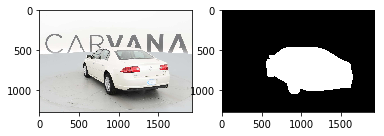

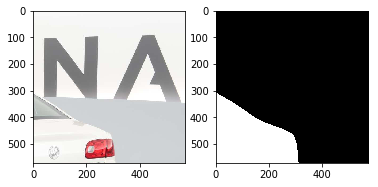

In [12]:
def random_crop(image_pair, dims):
    image, mask = image_pair
    w, h = image.size
    x_s = random.randint(0, w - dims[1])
    y_s = random.randint(0, h - dims[0])
    box = (x_s, y_s, x_s+dims[1], y_s+dims[0])
    image = image.crop(box)
    mask = mask.crop(box)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_crop((image_, mask_), input_dims)
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

In [13]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = image_.resize(image_size, resample=Image.BILINEAR)
mask_ = mask_.resize(image_size, resample=Image.BILINEAR)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 87.9 ms


In [14]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

CPU times: user 112 ms, sys: 4 ms, total: 116 ms
Wall time: 114 ms


(906, 640)
[[ 251.  251.  251.]
 [ 251.  251.  251.]
 [ 251.  251.  251.]
 ..., 
 [ 202.  202.  202.]
 [ 202.  202.  202.]
 [ 202.  202.  202.]]


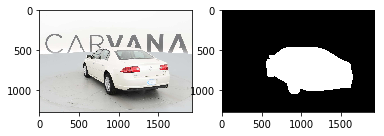

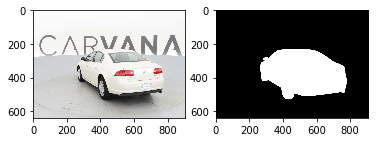

In [15]:
def resize_image(image_pair, dims):
    image, mask = image_pair
    image = image.resize(dims, resample=Image.BILINEAR)
    mask = mask.resize(dims, resample=Image.BILINEAR)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

(1918, 1280)
[[ 251.  251.  251.]
 [ 251.  251.  251.]
 [ 251.  251.  251.]
 ..., 
 [ 213.  213.  213.]
 [ 214.  214.  214.]
 [ 214.  214.  214.]]


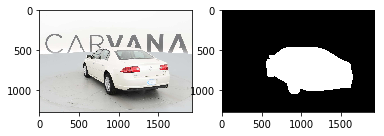

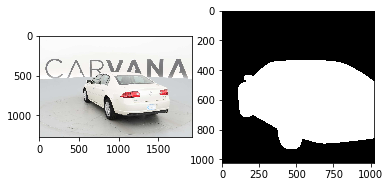

In [16]:
def cut_mask(image_pair, dims):
    assert dims[0] % 2 == 0 and dims[1] % 2 == 0, 'Output dims must be even numbers.'
    image, mask = image_pair
    # Because the image size is reversed of what we defined
    original_dims = image.size[::-1]
    x_s = (original_dims[1] - dims[1]) / 2
    y_s = (original_dims[0] - dims[0]) / 2
    box = (x_s, y_s, x_s+dims[1], y_s+dims[0])
    mask = mask.crop(box)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = cut_mask((image_, mask_), [1024, 1024])
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

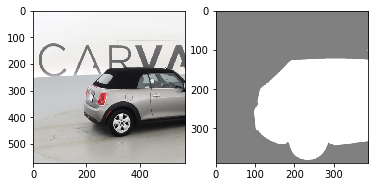

In [17]:
from data_utils import random_horizontal_flip
transform_resize = lambda image_pair: resize_image(image_pair, image_size)
transform_flip = lambda image_pair: random_horizontal_flip(image_pair, prob=0.5)
transform_crop = lambda image_pair: random_crop(image_pair, input_dims)
transform_cut = lambda image_pair: cut_mask(image_pair, output_dims)
transforms = [transform_resize, transform_flip, transform_crop, transform_cut]

from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [18]:
%%time
_ = next(train_gen)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 203 ms


In [19]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, 128, input_dims, transforms=transforms)

In [20]:
val_images, val_masks = next(val_gen)

In [21]:
print (val_images.shape)
print (val_masks.shape)

(128, 572, 572, 3)
(128, 388, 388, 1)


In [22]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_[0][150])
print (mask_[0].sum())

(1, 572, 572, 3)
(1, 388, 388, 1)
(388, 388, 1)
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]


## Build the network

In [23]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True, padding='same', verbose=1):
    conv1 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   input_layer)
    residual = Conv2D(filters, (3, 3), padding=padding, 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        if verbose:
            print ('Down output shape')
            print ('max_pool {}, residual {}'.format(K.int_shape(max_pool), K.int_shape(residual)))
        return max_pool,residual
    else:
        if verbose:
            print ('Down output shape')
            print ('residual {}'.format(K.int_shape(residual)))
        return residual
    
def up(input_layer, residual, filters, padding='same', cropping=0, verbose=1):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    if cropping != 0:
        residual = Cropping2D(cropping=cropping)(residual)

    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding=padding,
                   kernel_initializer=he_normal(), activation='relu')(
                   concat)
    conv2 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   conv1)
    if verbose:
        print ('Up output dims')
        print (K.int_shape(conv2))
    return conv2


In [24]:
K.clear_session()
# Make a custom U-nets implementation
padding = 'valid'
cropping = ((4, 4), (16, 16), (40, 40), (88, 88))
filters = 96
growth_factor = 1

input_layer = Input(shape=[None, None] + [3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters, padding=padding)
residuals.append(res1)

# Down 2, 64
filters = filters * growth_factor
d2, res2 = down(d1, filters, padding=padding)
residuals.append(res2)

# Down 3 32
filters = filters * growth_factor
d3, res3 = down(d2, filters, padding=padding)
residuals.append(res3)

# Down 4, 16
filters = filters * growth_factor
d4, res4 = down(d3, filters, padding=padding)
residuals.append(res4)

# Down 5, 8
filters = filters * growth_factor
d4 = Dropout(0.5)(d4)
d5 = down(d4, filters, pool=False, padding=padding)
d5 = Dropout(0.5)(d5)

# Up 1
filters = filters / growth_factor
up1 = up(d5, residual=residuals[-1], filters=filters, padding=padding, cropping=cropping[0])

# Up 2,3,4
up_ = up1
for layer_i in range(3):
    filters = filters / growth_factor
    up_ = up(up_, residual=residuals[-(layer_i + 2)], filters=filters, 
             padding=padding, cropping=cropping[layer_i+1])
    
# Out, or up 5
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid', padding=padding)(up_)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
residual (None, None, None, 96)
Up output dims
(None, None, None, 96)
Up output dims
(None, None, None, 96)
Up output dims
(None, None, None, 96)
Up output dims
(None, None, None, 96)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 96 2688   

In [27]:
# Parameters distribution
# For convnet, parameters number = size_w * size_h * pre_depth * 
# curr_depth
# increase intial depth by 2 will result 4x params 
# Down 
# 2k 37k
# 74k 148k
# 295k 590k
# 1180k 2400k
# 4720k 9438k
# Up
# 2098k 4719k 2360k
# 524k 1180k 590k
# 131k 295k 148k
# 33k 74k 37k
# 0k last 1x1 conv
# Total, 31032k

In [28]:
# Computation (multiply) 
# Down
# 3 * 64 * 9 * 570^2 = 561m
# 64 * 64 * 9 * 568^2 = 11893m
# 64 * 128 * 9 * 280^2 * 3 = 17340m
# 128 * 256 * 9 * 136^2 * 3 = 16264m
# 256 * 512 * 9 * 64^2 * 3 = 14496m
# 512 * 1024 * 9 * 28^2 * 3 = 11098m
# Down in all, 71652m
# Up
# 1024 * 512 * 4 * 56^2 = 6576m
# 1024 * 512 * 9 * 52^2 * 1.5 = 19139m
# 512 * 256 * 4 * 104^2 = 5671m
# 512 * 256 * 9 * 100^2 * 1.5 = 17695m
# 256 * 128 * 4 * 200^2 = 5243m
# 256 * 128 * 9 * 196^2 * 1.5 = 16994m
# 128 * 64 * 4 * 392^ 2 = 5035m
# 128 * 64 * 9 * 388^2 * 1.5 = 16648m
# Up in all, 93001m
# Omit last 1x1 conv and activation
# Total, 164653m ~ 0.16T
# Every layer, computation is almost the same, becasue the size decrease
# by a factor of 2, while filter increase by factor of 2
# Increase the filter size will significantly increase the computation
# Increase input size by 2, the number of multiplication will x4
# Increase intial depth by 2, the number of mutiplication will x4

In [25]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [26]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')

In [27]:
from callback2 import BatchHistory
del globals()['BatchHistory']
import callback2
reload(callback2)
from callback2 import BatchHistory
batch_history = BatchHistory(save_to=tmp_dir)

/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [33]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
             metrics=[dice_coef])

In [89]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2 / batch_size, 
                              callbacks=[checkpoint, csv_logger, batch_history], 
                              validation_data=(val_images[0:1], val_masks[0:1]), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

Epoch 1/2
2/2 [==============================] - 2s - loss: 0.6923 - dice_coef: 0.0384 - val_loss: 0.6921 - val_dice_coef: 0.0431
Epoch 2/2
2/2 [==============================] - 2s - loss: 0.6921 - dice_coef: 0.1284 - val_loss: 0.6917 - val_dice_coef: 0.0968


In [93]:
batch_hist = np.load(os.path.join(tmp_dir, 'batch_history.npy'))
print (batch_hist)

{'loss': [0.67868811, 0.70594501, 0.68358278, 0.70062172], 'dice_coef': [0.063484535, 0.013241945, 0.23067075, 0.026114309]}


In [34]:
reduce_lr = ReduceLROnPlateau()

In [98]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=(val_images, val_masks), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=10, 
                              initial_epoch=0)

Epoch 1/10
4096/4096 [==============================] - 4034s - loss: 0.3052 - dice_coef: 0.8590 - val_loss: 0.0841 - val_dice_coef: 0.9709
Epoch 2/10
4096/4096 [==============================] - 4019s - loss: 0.0528 - dice_coef: 0.9814 - val_loss: 0.0492 - val_dice_coef: 0.9832
Epoch 3/10
4096/4096 [==============================] - 4026s - loss: 0.0383 - dice_coef: 0.9868 - val_loss: 0.0291 - val_dice_coef: 0.9903
Epoch 4/10
4096/4096 [==============================] - 4076s - loss: 0.0276 - dice_coef: 0.9905 - val_loss: 0.0228 - val_dice_coef: 0.9925
Epoch 5/10
4096/4096 [==============================] - 4100s - loss: 0.0268 - dice_coef: 0.9908 - val_loss: 0.0312 - val_dice_coef: 0.9895
Epoch 6/10
4096/4096 [==============================] - 4219s - loss: 0.0233 - dice_coef: 0.9921 - val_loss: 0.0199 - val_dice_coef: 0.9935
Epoch 7/10
4096/4096 [==============================] - 4309s - loss: 0.0207 - dice_coef: 0.9930 - val_loss: 0.0189 - val_dice_coef: 0.9939
Epoch 8/10
4096/4096

In [38]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef}
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

In [39]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=(val_images, val_masks), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=14, 
                              initial_epoch=10)

Epoch 11/14
4096/4096 [==============================] - 4106s - loss: 0.0147 - dice_coef: 0.9951 - val_loss: 0.0142 - val_dice_coef: 0.9954
Epoch 12/14
4096/4096 [==============================] - 4083s - loss: 0.0145 - dice_coef: 0.9951 - val_loss: 0.0133 - val_dice_coef: 0.9956
Epoch 13/14
4096/4096 [==============================] - 4059s - loss: 0.0138 - dice_coef: 0.9954 - val_loss: 0.0133 - val_dice_coef: 0.9954
Epoch 14/14
4096/4096 [==============================] - 4086s - loss: 0.0135 - dice_coef: 0.9955 - val_loss: 0.0127 - val_dice_coef: 0.9957


In [38]:
def decrease_lr(optimizer):
    lr = K.get_value(optimizer.lr)
    K.set_value(optimizer.lr, lr / 10)
    print ('Decrease learning rate, now is {}'.format(lr / 10))
decrease_lr(optimizer)

Decrease learning rate, now is 0.00010000000474974513


In [30]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef}
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

from callback2 import BatchHistory
batch_history = BatchHistory(save_to=tmp_dir)

# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau()

In [31]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=(val_images, val_masks), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=30, 
                              initial_epoch=14)

Epoch 15/30
4096/4096 [==============================] - 4011s - loss: 0.0192 - dice_coef: 0.9936 - val_loss: 0.0344 - val_dice_coef: 0.9887
Epoch 16/30
4096/4096 [==============================] - 4012s - loss: 0.0184 - dice_coef: 0.9939 - val_loss: 0.0131 - val_dice_coef: 0.9955
Epoch 17/30
4096/4096 [==============================] - 4015s - loss: 0.0136 - dice_coef: 0.9954 - val_loss: 0.0119 - val_dice_coef: 0.9959
Epoch 18/30
4096/4096 [==============================] - 4023s - loss: 0.0127 - dice_coef: 0.9958 - val_loss: 0.0112 - val_dice_coef: 0.9961
Epoch 19/30
4096/4096 [==============================] - 4011s - loss: 0.0128 - dice_coef: 0.9957 - val_loss: 0.0113 - val_dice_coef: 0.9960
Epoch 20/30
4096/4096 [==============================] - 4006s - loss: 0.0118 - dice_coef: 0.9960 - val_loss: 0.0115 - val_dice_coef: 0.9959
Epoch 21/30
4096/4096 [==============================] - 4007s - loss: 0.0118 - dice_coef: 0.9961 - val_loss: 0.0113 - val_dice_coef: 0.9961
Epoch 22/30
4

In [32]:
model.save('tmp-wights.hdf5')